In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
import os
import sys

sys.path.append(os.path.abspath('..'))
warnings.simplefilter(action='ignore', category=FutureWarning)

# Caricamento del dataset
filename = '../data/temp/02_training_data_residuals.csv'
try:
    df = pd.read_csv(filename)
    print("Dataset caricato correttamente.")
except FileNotFoundError:
    print(f"Errore: il file '{filename}' non è stato trovato.")  

Dataset caricato correttamente.


### **Analisi della PCA**

La PCA (Analisi delle Componenti Principali) è una tecnica statistica utilizzata per **ridurre la complessità dei dati** (riduzione della dimensionalità) cercando di perdere la minor quantità possibile di informazioni.

L'analisi termina con l'implementazione di una **PCA per ogni fase di volo** e la visualizzazione dei risultati. Lo scopo è quello di osservare quali features sono più significative, se esistono features ridondanti e se eliminarne alcune.

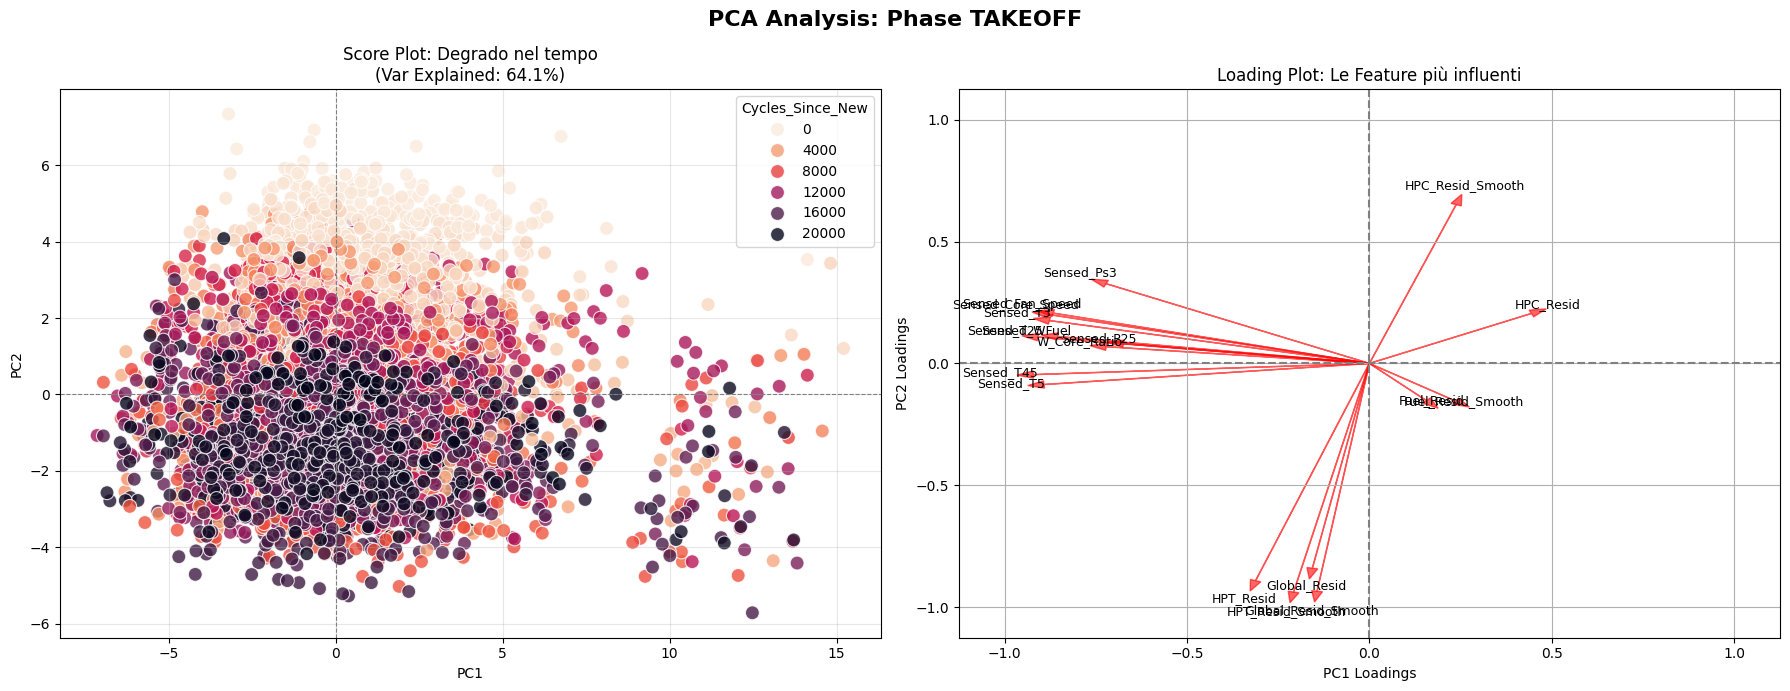


--- TOP FEATURES PER TAKEOFF ---
HPT_Resid_Smooth       0.960632
Global_Resid_Smooth    0.945461
HPT_Resid              0.944191
Sensed_T45             0.922471
Sensed_T25             0.914589
Sensed_Core_Speed      0.903909
Sensed_T5              0.896168
Sensed_T3              0.894453
Sensed_Fan_Speed       0.890944
Sensed_WFuel           0.861528
Global_Resid           0.854521
Sensed_Ps3             0.792370
W_Core_Ratio           0.724746
HPC_Resid_Smooth       0.693535
Sensed_P25             0.678986
HPC_Resid              0.489099
Fuel_Resid_Smooth      0.282424
Fuel_Resid             0.218399
Name: Magnitude, dtype: float64
----------------------------------------


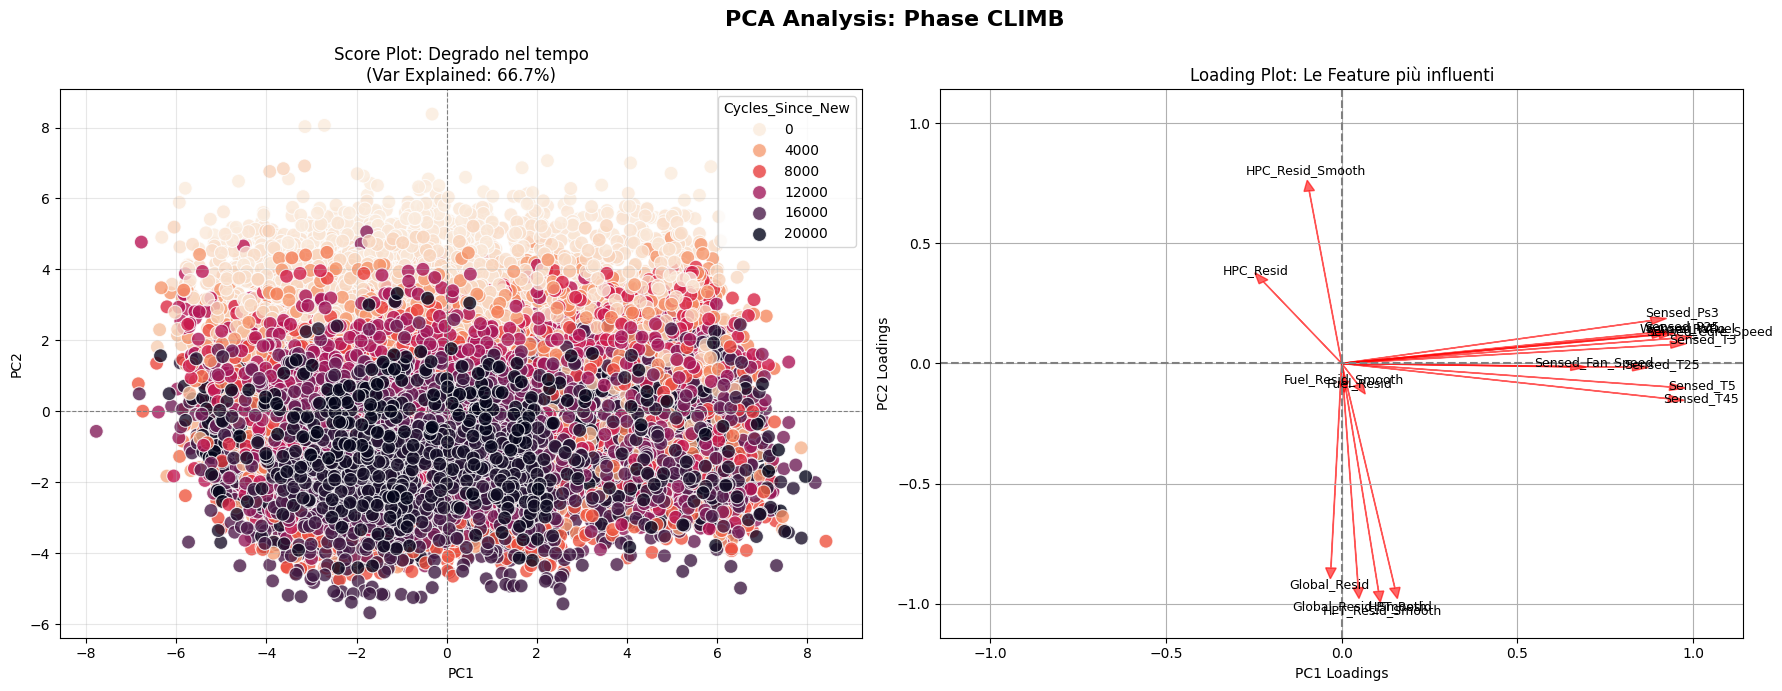


--- TOP FEATURES PER CLIMB ---
Sensed_Core_Speed      0.957514
HPT_Resid_Smooth       0.954808
HPT_Resid              0.946721
Sensed_T45             0.941867
Sensed_T3              0.938813
Sensed_T5              0.938554
Global_Resid_Smooth    0.934941
Sensed_WFuel           0.910600
Sensed_Ps3             0.898617
Sensed_P25             0.890366
W_Core_Ratio           0.890310
Global_Resid           0.852056
Sensed_T25             0.827593
HPC_Resid_Smooth       0.723905
Sensed_Fan_Speed       0.651659
HPC_Resid              0.406250
Fuel_Resid             0.099174
Fuel_Resid_Smooth      0.075260
Name: Magnitude, dtype: float64
----------------------------------------


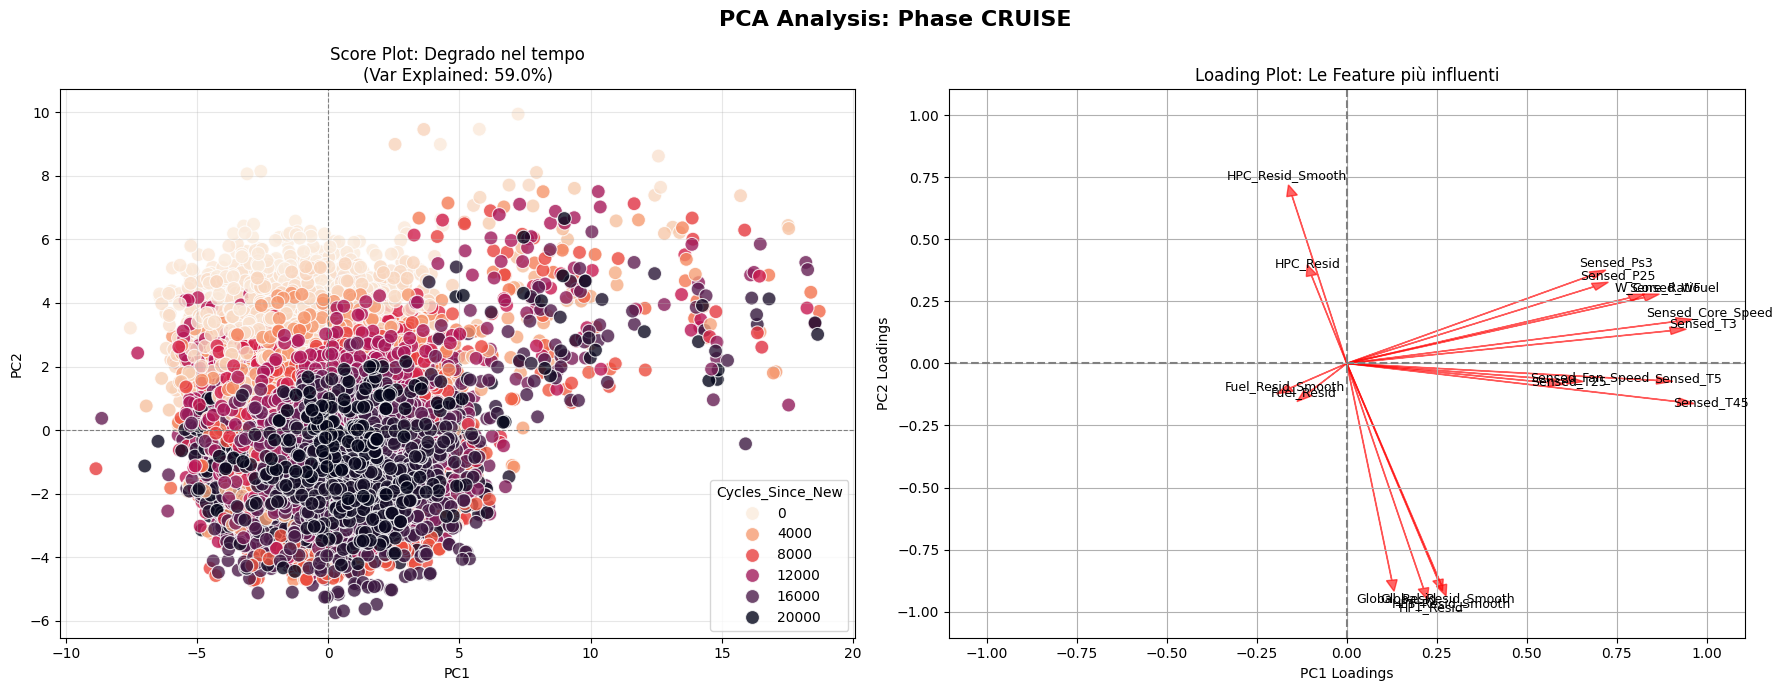


--- TOP FEATURES PER CRUISE ---
Sensed_T45             0.933899
Sensed_Core_Speed      0.931800
HPT_Resid_Smooth       0.931757
HPT_Resid              0.931266
Global_Resid_Smooth    0.908814
Sensed_T3              0.908541
Global_Resid           0.882245
Sensed_WFuel           0.867576
Sensed_T5              0.863800
W_Core_Ratio           0.828912
Sensed_Ps3             0.767362
Sensed_P25             0.752145
HPC_Resid_Smooth       0.692275
Sensed_Fan_Speed       0.616731
Sensed_T25             0.566241
HPC_Resid              0.367543
Fuel_Resid_Smooth      0.185330
Fuel_Resid             0.161974
Name: Magnitude, dtype: float64
----------------------------------------


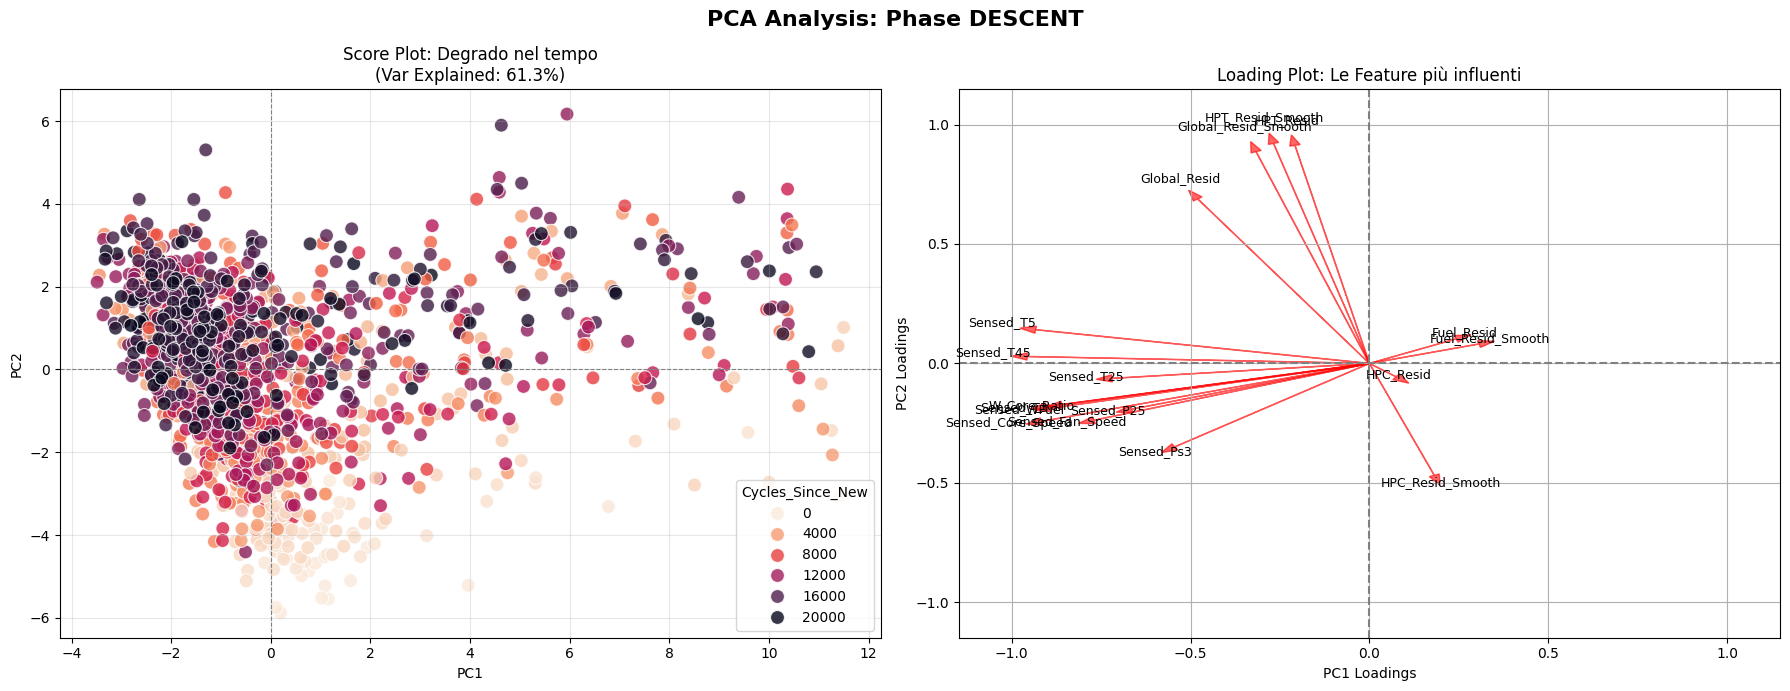


--- TOP FEATURES PER DESCENT ---
HPT_Resid_Smooth       0.959002
Sensed_T45             0.957149
Sensed_Core_Speed      0.948276
Sensed_T5              0.943672
Global_Resid_Smooth    0.941137
HPT_Resid              0.936070
Sensed_T3              0.920733
Sensed_WFuel           0.910651
W_Core_Ratio           0.876755
Global_Resid           0.839251
Sensed_Fan_Speed       0.806076
Sensed_T25             0.722278
Sensed_P25             0.692254
Sensed_Ps3             0.646669
HPC_Resid_Smooth       0.502015
Fuel_Resid_Smooth      0.317031
Fuel_Resid             0.263152
HPC_Resid              0.093071
Name: Magnitude, dtype: float64
----------------------------------------


In [2]:
cols_to_exclude = ['ESN', 'Snapshot', 'Cycles_Since_New', 'Flight_Phase',
                   'Sensed_Altitude', 'Sensed_Mach', 'Sensed_Pamb', 'Sensed_TAT',
                   'Sensed_VBV', 'Sensed_VAFN', 'Sensed_Pt2',
                   'Cumulative_WWs', 'Cumulative_HPC_SVs', 'Cumulative_HPT_SVs',
                   'Cycles_to_WW', 'Cycles_to_HPC_SV', 'Cycles_to_HPT_SV', 'Operational_Profile']
features = [c for c in df.columns if c not in cols_to_exclude]

# 3. Loop attraverso ogni Fase di Volo
unique_phases = df['Flight_Phase'].unique()

for phase in unique_phases:
    # Filtriamo il dataset per la fase corrente
    df_phase = df[df['Flight_Phase'] == phase].copy()
    
    # Se ci sono pochi dati, saltiamo la fase
    if len(df_phase) < 3:
        print(f"Skipping {phase}: Troppi pochi dati.")
        continue

    # Preparazione dati (Standardizzazione)
    x = df_phase.loc[:, features].values
    scaler = StandardScaler()
    x_std = scaler.fit_transform(x)

    # PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x_std)
    
    # DataFrame temporaneo per il plotting
    pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    pca_df['Cycles_Since_New'] = df_phase['Cycles_Since_New'].values
    
    # Calcolo Loadings (Importanza delle feature)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)
    loading_df['Magnitude'] = np.sqrt(loading_df['PC1']**2 + loading_df['PC2']**2)
    
    # --- VISUALIZZAZIONE ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'PCA Analysis: Phase {phase}', fontsize=16, fontweight='bold')

    # GRAFICO 1: Score Plot (Evoluzione temporale)
    sns.scatterplot(ax=axes[0], x="PC1", y="PC2", hue="Cycles_Since_New",
                    data=pca_df, palette="rocket_r", s=100, alpha=0.8)
    axes[0].set_title(f'Score Plot: Degrado nel tempo\n(Var Explained: {pca.explained_variance_ratio_.sum()*100:.1f}%)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(0, color='grey', linestyle='--', linewidth=0.8)
    axes[0].axvline(0, color='grey', linestyle='--', linewidth=0.8)

    # GRAFICO 2: Loading Plot (Quali feature pesano?)
    # Mostriamo solo le top 15 feature per pulizia
    top_features = loading_df.sort_values(by='Magnitude', ascending=False).head(50)
    
    # Calcolo limiti per centrare il grafico
    max_lim = top_features[['PC1', 'PC2']].abs().max().max() * 1.2
    
    for feature in top_features.index:
        axes[1].arrow(0, 0, top_features.loc[feature, 'PC1'], top_features.loc[feature, 'PC2'], 
                      color='red', alpha=0.6, head_width=0.03)
        axes[1].text(top_features.loc[feature, 'PC1']*1.1, top_features.loc[feature, 'PC2']*1.1, 
                     feature, color='black', ha='center', fontsize=9)
    
    axes[1].set_xlim(-max_lim, max_lim)
    axes[1].set_ylim(-max_lim, max_lim)
    axes[1].set_title('Loading Plot: Le Feature più influenti')
    axes[1].set_xlabel('PC1 Loadings')
    axes[1].set_ylabel('PC2 Loadings')
    axes[1].grid(True)
    axes[1].axhline(0, color='grey', linestyle='--')
    axes[1].axvline(0, color='grey', linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # Stampa testuale di supporto
    print(f"\n--- TOP FEATURES PER {phase} ---")
    print(top_features['Magnitude'].head(50))
    print("-" * 40)

#### **Analisi Fase CRUISE**

Osservando i grafici e i risultati, la fase di CRUISE risulta essere la più **standard**, quindi la più affidabile per la diagnosi.

La PCA ha identificato che il degrado si manifesta primariamente come un **aumento della temperatura (T45)** e una variazione della velocità del core per compensare la perdita di efficienza. Il fatto che i residui (`HPT` e `Global`) siano così alti conferma che il modello fisico (da cui derivano i residui) è sensibile al danno.

- **Score Plot**: l'immagine ha una forma a "V" o "a ventaglio" più dispersa orizzontalmente. Si nota una deriva, ma i cluster di colore tendono a sovrapporsi maggiormente. La varianza spiegata è inferiore rispetto al TAKEOFF. Ciò può descrivere come, in crociera, il motore è comodo. Il controllore (FADEC) compensa molto bene le piccole inefficienze, **mascherando il degrado fisico**. I residui qui sono spesso **sporchi** a causa della lunga durata e delle variazioni atmosferiche lente.

- **Loading Plot**: anche se mascherato, il degrado termico (`T45`) rimane visibile. Tuttavia, `HPC_Resid` scende (0.36).

- **Risultato**: Utile per il monitoraggio termico a lungo termine, ma meno sensibile ai guasti meccanici precoci rispetto al decollo.

#### **Analisi Fase TAKEOFF**

Osservando i grafici e i risultati, nella fase di TAKEOFF i residui **dominano sui sensori**. Infatti, durante il decollo la dinamica è violenta, quindi i sensori grezzi fluttuano molto. I residui (che sono la differenza tra modello e realtà) riescono invece a isolare l'anomalia meglio del valore assoluto.

- **Score Plot**: i dati formano una traiettoria curva, stretta e ben definita. C'è una **separazione chiara** tra i punti chiari (motore nuovo) e tra i punti scuri (motore vecchio). In questa fase il motore opera alla massima potenza, e il rapporto segnale/rumore è al suo picco massimo. La varianza è dominata quasi esclusivamente dallo stato di slaute del motore.

- **Loading Plot**: i vettori dominanti sono lunghi e coerenti, che spingono nella direzione dello Score Plot. Il fatto che `HPC_Resid` abbia qui il suo peso massimo (0.49) rispetto alle altre fasi conferma che il decollo è **l'unica fase in cui si vede bene lo stress del compressore**.

- **Risultato**: È la fase critica per l'addestramento. Se il modello non impara da qui, non imparerà da nessuna parte.

#### **Analisi Fase CLIMB**

Questa fase è molto simile al TAKEOFF, ma la velocità del core (`Core_Speed`) diventa il predittore numero uno. per mantenere la spinta richiesta mentre l'aria diminuisce, un motore degradato deve girare molto più veloce di uno sano.

- **Score Plot**: è simile al TAKEOFF, ma la nuvola di dati è molto più spessa. Inoltre si può osservare come i dati vengono **spinti simmetricamente** rispetto alla fase di TAKEOFF nella direzione opposta (verso destra). La direzione del degrado (PC1) è ancora dominante.

- **Loading Plot**: `Sensed_Core_Speed` (0.957) supera leggermente le temperature. Questo deriva sempre dal fatto che il sistema di controllo cerca di mantenere la velocità del core costante per garantire la spinta. Le deviazioni in `Core_Speed` qui sono indicatori forti che il motore sta faticando per salire.

- **Risultato**: Fase eccellente per corroborare i dati di decollo, specialmente per guasti legati alla rotazione (Speed) più che alla termica pura.

#### **Analisi Fase DESCENT**

L'analisi conferma che anche a basso regime l'inefficienza termica (`T45`) e l'errore del modello (`Resid`) rimangono visibili. Questa è una conferma di robustezza: il degrado si vede sempre, non solo in fase di decollo.

- **Score Plot**: il grafico è un caos. Non c'è una traiettoria pulita che va dal nuovo o al vecchio. Il motore è al minimo o in transitorio negativo.

- **Loading Plot**: le feature _Smooth_ sembrano alte (0.95), ma quelle raw (`HPC_Resid`, `Fuel_Resid`) crollano a 0.09 e 0.26. La PCA sulle variabili _Smooth_ inganna: sta vedendo la correlazione matematica della media mobile, non la fisica del motore. Il segnale fisico grezzo è assente (magnitudine < 0.1).

- **Risultato**: Questa fase è da scartare, poiché inserirla nel modello aggiungerà solo rumore e overfitting.

---

### **Scelta delle Fasi e Features finali**

Come passaggio finale della fase di ETL, si andranno a **scartare** le seguenti features:

- `Fuel_Resid` e `Fuel_Resid_Smooth`: **non sono risultate significative** per nessuna fase, con segnali troppi deboli e rumore. Queste variabili sono sempre in fondo alla classifica con valori molto bassi (0.09 o 0.21). Quindi, inserire una variabile che la PCA giudica inutile rischia di confondere il modello. A questo proposito è stata inserita la colonna `Operational_Profile`, come descritto in precedenza.

- Features Residui Raw (`HPT_Resid`, `Global_Resid`, ...): si tengono solo le `_Smooth` per ridondanza estrema (collinearità). La versione Smooth elimina i picchi anomali che **potrebbero confondere il modello** tra un vero guasto e un falso allarme. Inoltre, tenere entrambe le colonne potrebbe creare instabilità matematica in alcuni algoritmi.

- `Sensed_T25`, `Sensed_P25` e `Sensed_T3`: l'informazione è già presente altrove. Inoltre, T25 e P25 sono la temperatura e pressione all'ingresso del compressore, che **dipendono quasi esclusivamente dalle condizioni atmosferiche** (quota e velocità). Poichè sono presenti `Sensed_Altitude`, `Sensed_Mach` e `Sensed_TAT`, il modello sa già tutto quello che serve sulle condizioni di ingresso.

- `Sensed_Pamb`: questa feature è ridondante, poiché fortemente correlata con `Sensed_Altitude`, come già visto fin dall'inizio dell'analisi.

- `Sensed_Fan_Speed` (N1): questo sensore **misurava il comando, non la salute**. Questa velocità è il parametro che il computer di bordo cerca di mantenere costante per dare la spinta richiesta. Il vero segnale è la `Sensed_Core_Speed` (N2), che è esposta al degrado vero. Se il motore è usurato, per mantenere la stessa N1 (Fan), il nucleo (N2) deve girare più veloce e scaldare di più (T45).

- `Sensed_VBV` e `Sensed_VAFN`: la loro complessità, per ora, non è necessaria. Queste sono valvole che si aprono e chiudono "a scatto" o seguendo logiche complesse del software di controllo, non necessariamente legate all'usura fisica immediata. Includerle ora potrebbe aggiungere "salti" nei dati che il modello faticherebbe a interpretare.

Inoltre, poiché il modello deve imparare da situazioni fisiche diverse, bisogna fornire degli **interruttori digitali** per capire in che fase si trova l'aereo.

La colonna `Flight_Phase` è stata trasformata utilizzando **One-Hot Encoding**: sono state quindi create le colonne `Phase_TAKEOFF`, `Phase_CLIMB`, `Phase_CRUISE`, con valori 0 o 1. Se `Phase_TAKEOFF` è 1, il modello sa di dover pesare i sensori come massimo sforzo. Se `Phase_CRUISE` è 1, si aspetta dati stabili. Senza queste, il modello mescolerebbe tutti i dati.

Come già accennato in precedenza, avendo più fasi, l'ambiente cambia drasticamente. Quindi, bisogna dire al modello dove siamo: per questo sono state inserite `Sensed_Altitude`, `Sensed_Mach` e `Sensed_TAT`.

Il resto delle features rimangono invariate e sono state selezionate come **fondamentali** per l'apprendimento del modello.

In [3]:
output_file = '../data/processed/final_training_data.csv'

# Si scarta la fase DESCENT
phases_to_drop = ['DESCENT']
df_final = df[~df['Flight_Phase'].isin(phases_to_drop)].copy()

print(f"Righe dopo il filtro (Takeoff + Climb + Cruise): {df_final.shape[0]}")
print(f"Fasi rimaste: {df_final['Flight_Phase'].unique()}")


# Trasforma la colonna "Flight_Phase" in colonne numeriche:
# Flight_Phase_CLIMB, Flight_Phase_CRUISE, Flight_Phase_TAKEOFF (0 o 1)
df_final = pd.get_dummies(df_final, columns=['Flight_Phase'], prefix='Phase', dtype=int)


# Sensori e residui
features_sensors = [
    'HPT_Resid_Smooth',
    'HPC_Resid_Smooth',
    'Global_Resid_Smooth',
    'Sensed_T45',
    'Sensed_Core_Speed',
    'Sensed_WFuel',
    'Sensed_Ps3',
    'W_Core_Ratio'
]

# Features ambientali
features_env = [
    'Sensed_TAT',
    'Sensed_Altitude',
    'Sensed_Mach'
]

# Features di fase
features_phases = [col for col in df_final.columns if col.startswith('Phase_')]

# Features di contesto e storia
features_history = [
    'Cycles_Since_New',
    'Cumulative_WWs',
    'Cumulative_HPC_SVs',
    'Cumulative_HPT_SVs'
]

# Metadati target
features_meta = ['ESN', 'Operational_Profile']
targets = ['Cycles_to_HPT_SV', 'Cycles_to_HPC_SV', 'Cycles_to_WW']

selected_columns = features_meta + features_phases + features_sensors + features_env + features_history + targets

try:
    df_model = df_final[selected_columns].copy()

    df_model.dropna(inplace=True)

    print("\n--- DATASET FINALE PRONTO ---")
    print(df_model.info())
    print("\nPrime 5 righe:")
    print(df_model.head())

    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    df_model.to_csv(output_file, index=False)
    print(f"\nSalvataggio completato in: {output_file}")

except KeyError as e:
    print(f"\nERRORE: Colonna mancante -> {e}")

Righe dopo il filtro (Takeoff + Climb + Cruise): 49773
Fasi rimaste: ['TAKEOFF' 'CLIMB' 'CRUISE']

--- DATASET FINALE PRONTO ---
<class 'pandas.core.frame.DataFrame'>
Index: 49773 entries, 0 to 51395
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ESN                  49773 non-null  int64  
 1   Operational_Profile  49773 non-null  int64  
 2   Phase_CLIMB          49773 non-null  int32  
 3   Phase_CRUISE         49773 non-null  int32  
 4   Phase_TAKEOFF        49773 non-null  int32  
 5   HPT_Resid_Smooth     49773 non-null  float64
 6   HPC_Resid_Smooth     49773 non-null  float64
 7   Global_Resid_Smooth  49773 non-null  float64
 8   Sensed_T45           49773 non-null  float64
 9   Sensed_Core_Speed    49773 non-null  float64
 10  Sensed_WFuel         49773 non-null  float64
 11  Sensed_Ps3           49773 non-null  float64
 12  W_Core_Ratio         49773 non-null  float64
 13  Sensed_TAT  